<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generative-Model-Overview" data-toc-modified-id="Generative-Model-Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generative Model Overview</a></span></li><li><span><a href="#Normal-Distribution" data-toc-modified-id="Normal-Distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Normal Distribution</a></span></li><li><span><a href="#Gaussian-Mixture-Models" data-toc-modified-id="Gaussian-Mixture-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gaussian Mixture Models</a></span><ul class="toc-item"><li><span><a href="#Bayesian-Information-Criterion" data-toc-modified-id="Bayesian-Information-Criterion-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Bayesian Information Criterion</a></span></li></ul></li><li><span><a href="#Generative-Models-in-High-Dimensions" data-toc-modified-id="Generative-Models-in-High-Dimensions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generative Models in High Dimensions</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Create-a-GMM-that-can-generate-new-examples-of-the-digit-6" data-toc-modified-id="Exercise:-Create-a-GMM-that-can-generate-new-examples-of-the-digit-6-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exercise: Create a GMM that can generate new examples of the digit 6</a></span></li></ul></li><li><span><a href="#Kernel-Density-Estimation" data-toc-modified-id="Kernel-Density-Estimation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Kernel Density Estimation</a></span><ul class="toc-item"><li><span><a href="#KDE-vs.-Histograms" data-toc-modified-id="KDE-vs.-Histograms-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>KDE vs. Histograms</a></span></li><li><span><a href="#KDE-in-high-dimensions" data-toc-modified-id="KDE-in-high-dimensions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>KDE in high dimensions</a></span></li></ul></li></ul></div>

# Generative Models

Generative models describe the probability distribution of the underlying data. They can be used to explore datasets in many different ways, and are **unsupervised** since they do not require labels for the output data.

## Generative Model Overview

Generative models provide an estimate of the probability of finding data at a particular point in feature space. Written mathematically:

$P(data|features)$

These models can then be used to generate synthetic data that mimics the input data by sampling the probability distribution.

Some uses of generative models:

* augment sparse/imbalanced datasets
* refine supervised models
* visualize data distributions

## Normal Distribution

The 1-dimensional normal distribution is the simplest case of a generative model. We have worked with the Gaussian distribution a lot, but here we will import a different implementation from the `scipy.stats` package:

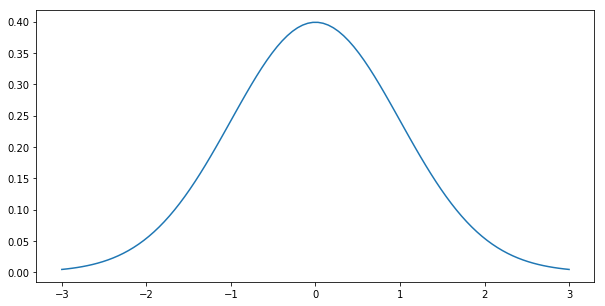

In [2]:
%matplotlib inline
import pylab as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
gauss = norm.pdf(x, mu, sigma)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x,gauss)

We are now extracting the `pdf`, or "probability density function" from the `norm` package rather than writing it out explicitly. However, this is exactly the same Gaussian distribution we have seen many times.

We can now use the `norm` function to generate new samples from this distribution:

(100000,)


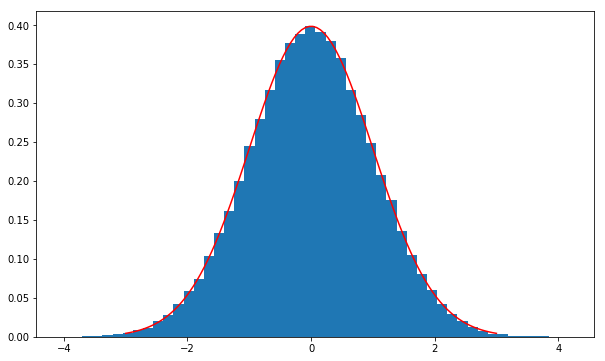

In [7]:
X_new = norm.rvs(mu, sigma, size=100000)
print(X_new.shape)
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(X_new,density=True,bins=50)
ax.plot(x,norm.pdf(x, mu, sigma),color='r')

This is a "generative" model because we can generate new data points once we know the parameters of the distribution. In practice, we will see that generative models are almost always composed of combinations of different Gaussian distributions, so the same basic machinery (sampling a normal distribution) can be used even for more complex models.

Let's take a look at the Dow dataset and see if we can create a generative model for one of the features.

In [8]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X_dow = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y_dow = np.array(all_data[real_rows,-3], dtype='float')
y_dow = y_dow.reshape(-1,1)
print(X_dow.shape, y_dow.shape)

(10297, 40) (10297, 1)


We can select one of the features and check the histogram:

(array([2.610e+02, 1.000e+00, 3.800e+01, 1.621e+03, 8.347e+03, 1.800e+01,
        4.000e+00, 3.000e+00, 3.000e+00, 1.000e+00]),
 array([-1.27182000e-01,  1.35071362e+01,  2.71414544e+01,  4.07757726e+01,
         5.44100908e+01,  6.80444090e+01,  8.16787272e+01,  9.53130454e+01,
         1.08947364e+02,  1.22581682e+02,  1.36216000e+02]),
 <a list of 10 Patch objects>)

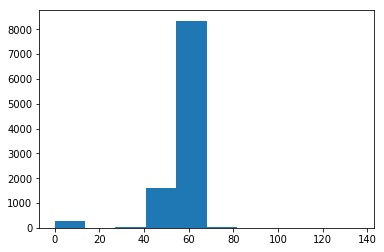

In [9]:
feature = 6
x_1d = X_dow[:,feature]

fig, ax = plt.subplots()
ax.hist(x_1d)

Now we can easily create a generative model by assuming this data is Gaussian. We just need to compute the mean and standard deviation, then we can create new synthetic data points and compare:

(array([0.00062511, 0.0046883 , 0.01343979, 0.03094277, 0.04110075,
        0.04063192, 0.01828436, 0.00546968, 0.00078138, 0.00031255]),
 array([24.44937939, 30.84828951, 37.24719964, 43.64610976, 50.04501989,
        56.44393002, 62.84284014, 69.24175027, 75.6406604 , 82.03957052,
        88.43848065]),
 <a list of 10 Patch objects>)

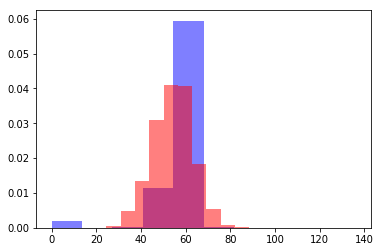

In [10]:
mu = x_1d.mean()
std = x_1d.std()

x_synthetic = norm.rvs(mu, std, size=1000)

fig, ax = plt.subplots()
ax.hist(x_1d,density=True, color='b', alpha=0.5)
ax.hist(x_synthetic,density=True, color='r', alpha=0.5)

We can see that the distributions are similar, but don't exactly match. This is because the original data was not really normally distributed. This is also only a single feature, but the actual dataset has 40 features, so we really aren't generating a new datapoint.

## Gaussian Mixture Models

We can move beyond 1-dimensional normal distributions using GMM's. Let's take a look at the distribution of 2 features at once:

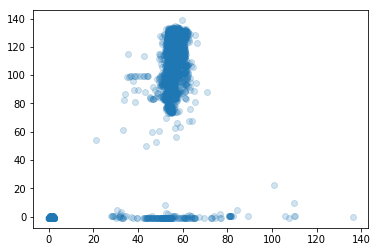

In [11]:
feature_A = 6
feature_B = 4
X_2d = X_dow[:, [feature_A, feature_B]]

fig,ax = plt.subplots()
ax.scatter(X_2d[:,0], X_2d[:,1], alpha=0.2)

We can see that this is very far from being a Gaussian distribution. However, we can still model it with a GMM.

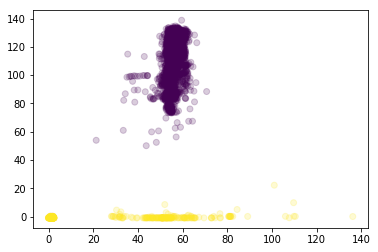

In [12]:
from sklearn.mixture import GaussianMixture
N_clusters = 2
gmm = GaussianMixture(n_components=N_clusters, covariance_type='full', random_state=0)
gmm.fit(X_2d)
y_2d = gmm.predict(X_2d)

fig,ax = plt.subplots()
ax.scatter(X_2d[:,0], X_2d[:,1], alpha=0.2, c=y_2d)

We can see that the model has now identified 2 different clusters. However, we can also think of this as one single probability distribution. To visualize this we will use some helper functions modified from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb). You do *not* need to understand how these work, just realize they allow us to plot the GMM distribution in 2d.

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
        
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=0)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=0)
    ax.axis('equal')
    
    w_factor = 0.5
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax=ax, alpha= w_factor)
    return ax

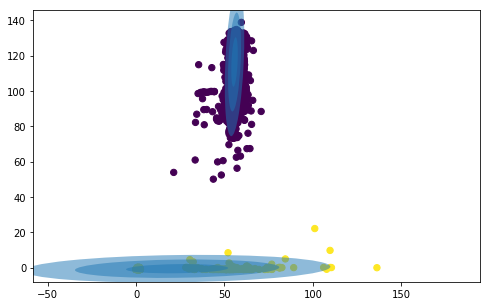

In [14]:
plot_gmm(gmm, X_2d)

We see that with 2 Gaussians the distribution does not seem to match the data well. However, if we keep increasing the number of Gaussians the agreement will get much better: 

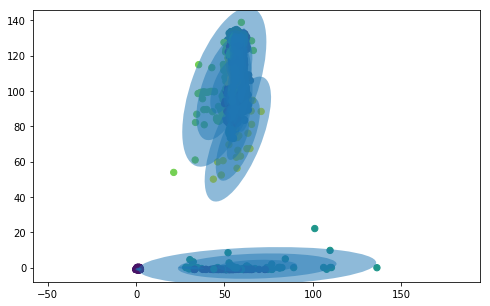

In [16]:
N_clusters = 20
gmm = GaussianMixture(n_components=N_clusters, covariance_type='full', random_state=0)
plot_gmm(gmm, X_2d)

The GMM model has a built-in feature that makes it easy to draw new samples. Let's create a synthetic dataset and compare it:

Text(0.5,1,'Synthetic Data')

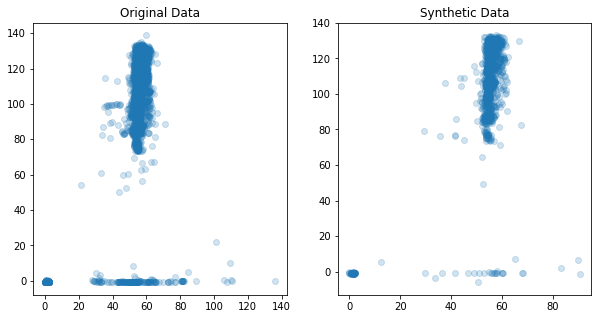

In [18]:
X_new, y_new = gmm.sample(2000)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(X_2d[:,0], X_2d[:,1], alpha=0.2)
axes[0].set_title('Original Data')
axes[1].scatter(X_new[:,0], X_new[:,1], alpha=0.2)
axes[1].set_title('Synthetic Data')

They still aren't perfect, but the main features are clearly present. However, we could keep adding more Gaussians, and it isn't clear how many are too many.

### Bayesian Information Criterion

To determine the right number of Gaussians we can revisit the concept of the Bayesian Information Criterion. The formula is a little complex for GMM's, but fortunately it is built in. We can evaulate the BIC as a function of the number of clusters. 

In this case the formulat for the BIC is:

The Bayesian information criterion (BIC) is defined as:

$BIC = \ln{(n)}*k - 2*\ln{(\hat{L})}$

where $(\hat{L})$ is the probability that the data drawn from the GMM comes from the same distribution as the underlying data. This is complex to calculate, and luckily it is already implemented in the `bic` method.

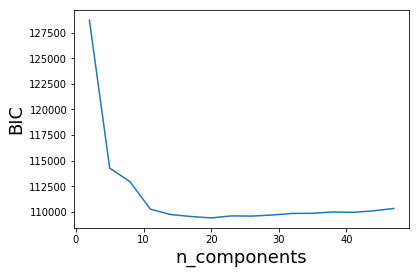

In [19]:
n_components = np.arange(2, 50)[::3]

BICs = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type='full').fit(X_2d)
    bic = gmm_n.bic(X_2d)
    BICs.append(bic)
    
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('n_components', size=18);
ax.set_ylabel('BIC', size=18);

We see that the BIC is minimum around 20 components, so our 20-cluster model is the best approximation we can get with GMMs.

## Generative Models in High Dimensions

One issue with GMM's is that they do not scale well with the number of dimensions. This is particularly true if the full covariance matrix is optimized, since the covariance matrix has a number of parameters that scales with ~$\frac{1}{2}N_d^2$ where $N_d$ is the number of dimensions. Sometimes the "blessing of dimensionality" also helps, since data looks more like Gaussians as the number of dimensions increases, but this is not something we can count on.

One strategy to deal with this is to combine a GMM model with an invertible dimensionality reduction approach. For this example we will return to the MNIST dataset:

In [20]:
from sklearn.datasets import load_digits

digits = load_digits()
print("Digits data shape: {}".format(digits.data.shape))
print("Digits output shape: {}".format(digits.target.shape))
X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

Digits data shape: (1797, 64)
Digits output shape: (1797,)


As before, we will use the `show_image` function:

In [21]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    ax.imshow(img,cmap='binary')    

First, let's try to find the optimal GMM for the high-dimensional space:

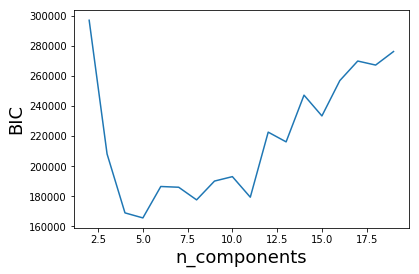

In [22]:
n_components = np.arange(2, 20)

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type='full').fit(X_mnist)
    bic = gmm_n.bic(X_mnist)
    BICs.append(bic)
    models.append(gmm_n)
    
        
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('n_components', size=18);
ax.set_ylabel('BIC', size=18);

We see that the optimal seems to be below 10. This is a bit surprising, since we know there are 10 digits in the dataset. Let's try to create some new digits with the best model:

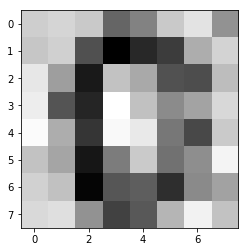

In [39]:
gmm_best = models[5]
example = gmm_best.sample()
show_image(example, 0)

The output of these blocks will change every time, but we see that there is some resemblance to digits. We can reduce the number of parameters by using `spherical` or `tied` Gaussian distributions instead:

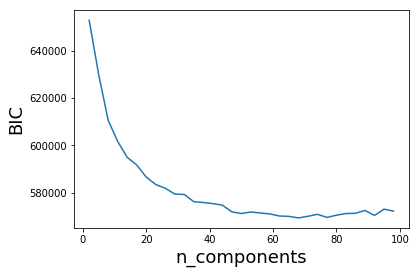

In [30]:
n_components = np.arange(2, 100)[::3]

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type='spherical').fit(X_mnist)
    bic = gmm_n.bic(X_mnist)
    BICs.append(bic)
    models.append(gmm_n)
    
        
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('n_components', size=18);
ax.set_ylabel('BIC', size=18);

We see that we now need many more Gaussians. This makes sense, because each one has far fewer parameters. Let's look at some example digits:

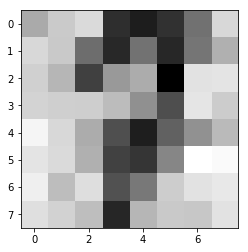

In [38]:
min_idx = BICs.index(min(BICs))
gmm_best = models[min_idx]
example = gmm_best.sample()
show_image(example, 0)

In general, these look worse! We could have predicted this by comparing the BIC's between the two approaches. Finally, let's combine the GMM with PCA:

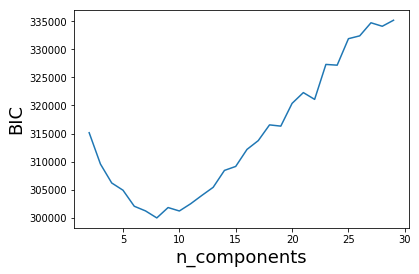

In [40]:
from sklearn.decomposition import PCA

k = 30
pca_model = PCA(n_components=k)
pca_model.fit(X_mnist)
X_k = pca_model.transform(X_mnist)

n_GMM = np.arange(2, 30)

BICs = []
models = []
for n in n_GMM:
    gmm_n =  GaussianMixture(n, covariance_type='full').fit(X_k)
    bic = gmm_n.bic(X_k)
    BICs.append(bic)
    models.append(gmm_n)
    
            
fig, ax = plt.subplots()
ax.plot(n_GMM, BICs)
ax.set_xlabel('n_components', size=18);
ax.set_ylabel('BIC', size=18);

Now we can draw from the low-dimensional distribution and use the inverse transform to go back to the high-dimensional space:

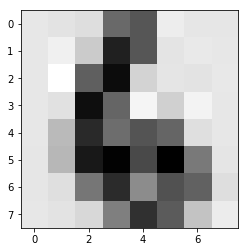

In [51]:
min_idx = BICs.index(min(BICs))
gmm_best = models[min_idx]
example_lowD, out = gmm_best.sample()

example_lowD = example_lowD.reshape(1,-1)
example = pca_model.inverse_transform(example_lowD)
show_image(example, 0)

In general these seem to be comparable to the samples generated from creating a GMM on the full distribution, but the model is more efficient because it is sampling from a lower-dimensional space. In practice, if you are working with data with dimensions >100 it will likely be necessary to combine dimensional reduction and GMM's to create a generative model.

### Exercise: Create a GMM that can generate new examples of the digit 6

Follow the same procedures above, but only use input data from the digit 6. You can use the `y_mnist` variable to quickly select this subset (`y_mnist == 6`).

## Kernel Density Estimation 

In Gaussian mixture models we represent data with a combination of Gaussians. As we increase the number of Gaussians the distribution gets closer to the original data, but the ability to "generalize" to new data decreases.

Kernel density estimation (KDE) takes Gaussian mixtures to their logical extreme by representing the distribution with the same number of Gaussians as data points. This enables it to represent arbitrarily complex distributions relatively well. You can think of it as interpolation for probability distributions.

### KDE vs. Histograms

One issue with histograms is that they can be very sensitive to how the bins are selected. KDE models offer an alternative to histograms that do not require bins, but do require a "bandwidth" (the width of the Gaussians used to represent the distribution). Let's revisit the example of the distribution from the feature from the Dow dataset and compare a histogram to the KDE model:

Text(0,0.5,'P(X)')

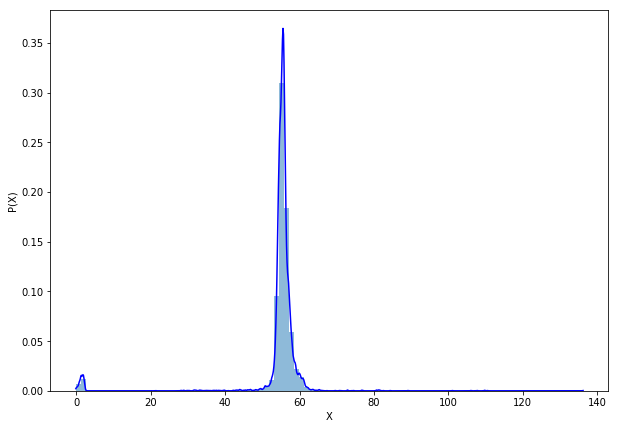

In [61]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
x_1d = x_1d.reshape(-1,1)
kde = KernelDensity(bandwidth=0.15, kernel='gaussian')
kde.fit(x_1d)

#create a continuous x variable
x_continuous = np.linspace(min(x_1d), max(x_1d), 1000)

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_continuous)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(x_continuous, np.exp(logprob), '-b')
ax.hist(x_1d, alpha=0.5, density=True, bins=100)
ax.set_xlabel('X')
ax.set_ylabel('P(X)')

Similar to GMM's, we can use a KDE distribution to create new samples:

Text(0,0.5,'P(X)')

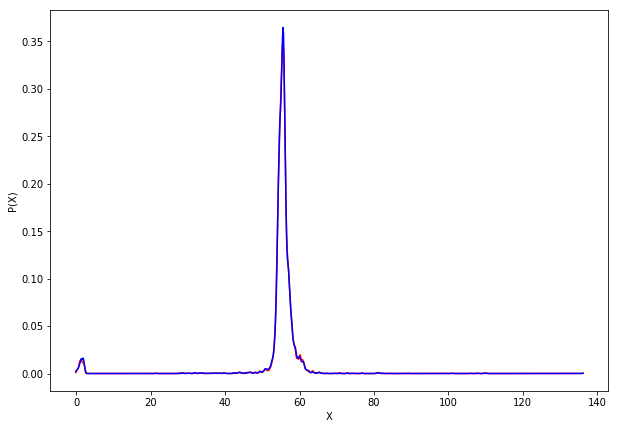

In [62]:
X_synthetic = kde.sample(10000)
X_synthetic = X_synthetic.reshape(-1, 1)
kde = KernelDensity(bandwidth=0.15, kernel='gaussian')
kde.fit(X_synthetic)

# score_samples returns the log of the probability density
logprob_synthetic = kde.score_samples(x_continuous)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(x_continuous, np.exp(logprob_synthetic), 'r')
ax.plot(x_continuous, np.exp(logprob), 'b')
ax.set_xlabel('X')
ax.set_ylabel('P(X)')

We see that the samples we draw now follow an almost identical distribution!

### KDE in high dimensions

Since KDE uses kernels, it generally scales realtively well to high dimensions. We can use it directly on the MNIST dataset to try to generate new samples:

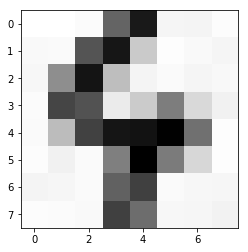

In [70]:
kde_images = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_images.fit(X_mnist)
example = kde_images.sample()
show_image(example, 0)

We see that these are very reasonable examples of hand-written digits, but they were generated by the computer! This concept can create very complex synthetic data. Perhaps the best example is faces of people who do not actually exist, as available from https://www.thispersondoesnotexist.com/. These are generated by much more sophisticated deep neural networks generative models, but the principle is the same.